In [9]:
import pandas as pd

file_path = "/Users/ksw00/PycharmProjects/pythonProject/DSL_EDA/서울 시민의 소비 및 이동 패턴 재현 데이터.csv"

# CSV 파일을 데이터프레임으로 읽기
df = pd.read_csv(file_path, usecols= ['연체여부','총대출약정금액','추정연소득','할부이용금액','대출여부'])

기준 1. 상환 이력 - 연체여부

상환 이력이란 기존의 대출을 얼마나 문제없이 갚았는지를 파악하는 항목입니다. 특히 ‘장기연체’가 있으면 신용점수에 있어 감점요인

기준 2. 부채 수준 - 총대출약정금액과 추정연소득 비율

상환이력과 같은 맥락입니다. 부채*를 잘 상환하는지, 소득 대비 부채 수준이 너무 높지 않은지를 판단해서 신용점수에 반영합니다.

기준 3. 신용 거래 기간 - ?

신용 거래 기간은 언뜻 보면 할부 기간이 길수록 좋은 것일까 오해할 수 있습니다. 여기에서 신용 거래 기간은 신용카드 개설 기간입니다. 신용카드 개설 기간이 길다는 것은 그만큼 신용 거래를 오래 했다는 것으로, 신용점수에 플러스 요인으로 작용합니다.

기준 4. 신용 거래 형태 - 할부이용금액, 대출여부

일상적인 카드 사용 형태를 기준으로 신용카드 대출이 많지는 않은지, 할부거래가 많지는 않은지를 봅니다. 이와 함께 다른 사람의 보증을 서주지는 않았는지를 봅니다

In [10]:
df

,대출여부,연체여부,추정연소득,총대출약정금액,할부이용금액
0,0,0,59000.0,0,595
1,0,0,26000.0,0,0
2,1,0,24000.0,27600,0
3,1,0,46000.0,12990,1628
4,0,0,30000.0,0,0
...,...,...,...,...,...
995,1,0,32000.0,40000,0
996,1,0,74000.0,41200,0
997,1,0,39000.0,309048,0
998,1,0,43000.0,237000,790


1.881068382906545


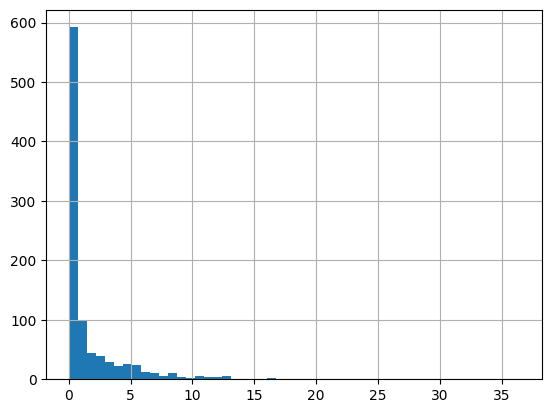

In [11]:
df['debt_ratio'] =  df['총대출약정금액'] / df['추정연소득']
print(df['debt_ratio'].mean())
f_df = df[df['debt_ratio'] <= 40]
f_df['debt_ratio'].hist(bins = 50)

percentiles = df['debt_ratio'].quantile([0.25, 0.5, 0.75])
installment_percentiles = df['할부이용금액'].quantile([0.25, 0.5, 0.75])

<Axes: >

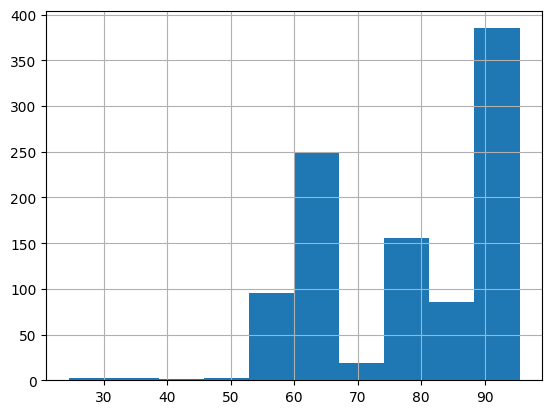

In [13]:
def calculate_credit_score(row):
    # 상환 이력 (30%)
    repayment_score = 100 if row['연체여부'] == 0 else 0
    
    # 부채 수준 (25%)
    debt_ratio = row['총대출약정금액'] / row['추정연소득']

    if debt_ratio <= percentiles[0.25]:
        debt_score = 100  # 최상위 점수
    elif debt_ratio <= percentiles[0.5]:
        debt_score = 80   # 상위 점수
    elif debt_ratio <= percentiles[0.75]:
        debt_score = 60   # 중간 점수
    else:
        debt_score = 20   # 하위 점수
    
    # 신용거래기간 (15%) - 기본값 사용
    transaction_duration_score = 70  # 고정 점수 예시
    
    # 신용거래형태 (30%)
    # 대출 여부와 할부 이용 금액에 따른 점수
    if row['대출여부'] == 1:
        if row['할부이용금액'] > installment_percentiles[0.75]:
            transaction_type_score = 30  # 대출 있음 & 할부 금액 매우 높음
        elif row['할부이용금액'] > installment_percentiles[0.5]:
            transaction_type_score = 50  # 대출 있음 & 할부 금액 높음
        elif row['할부이용금액'] > installment_percentiles[0.25]:
            transaction_type_score = 60  # 대출 있음 & 할부 금액 중간
        else:
            transaction_type_score = 70  # 대출 있음 & 할부 금액 낮음
    else:
        if row['할부이용금액'] > installment_percentiles[0.75]:
            transaction_type_score = 70  # 대출 없음 & 할부 금액 매우 높음
        elif row['할부이용금액'] > installment_percentiles[0.5]:
            transaction_type_score = 85  # 대출 없음 & 할부 금액 높음
        elif row['할부이용금액'] > installment_percentiles[0.25]:
            transaction_type_score = 90  # 대출 없음 & 할부 금액 중간
        else:
            transaction_type_score = 100  # 대출 없음 & 할부 금액 낮음
    
    # 최종 점수 계산
    total_score = (
        0.3 * repayment_score +
        0.25 * debt_score +
        0.15 * transaction_duration_score +
        0.3 * transaction_type_score
    )
    return total_score

df['신용등급'] = df.apply(calculate_credit_score, axis=1)
df['신용등급'].hist(bins=10)